# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Bell_pepper/train",
    label_mode="categorical",
    class_names= ['Pepper bell Bacterial spot', 'Pepper bell healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Bell_pepper/test",
    label_mode="categorical",
    class_names= ['Pepper bell Bacterial spot', 'Pepper bell healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 4033 files belonging to 2 classes.
==========================Validation Data====================
Found 962 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Bell_pepper/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Bell_pepper/test",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 4033 images belonging to 2 classes.
Found 962 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Wed May 24 16:54:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P0               29W /  N/A|   4545MiB /  6144MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## MobileNetV2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="BellPaper_MobileNetV2_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
202/202 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.9489
Epoch 1: val_accuracy improved from -inf to 0.51663, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 44s 185ms/step - loss: 0.3662 - accuracy: 0.9489 - val_loss: 14.6067 - val_accuracy: 0.5166 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9700
Epoch 2: val_accuracy improved from 0.51663 to 0.84407, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 176ms/step - loss: 0.1029 - accuracy: 0.9700 - val_loss: 1.7256 - val_accuracy: 0.8441 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9836
Epoch 3: val_accuracy did not improve from 0.84407
202/202 [==============================] - 21s 104ms/step - loss: 0.0461 - accuracy: 0.9836 - val_loss: 4.2856 - val_accuracy: 0.5946 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9876
Epoch 4: val_accuracy improved from 0.84407 to 0.84823, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 178ms/step - loss: 0.0347 - accuracy: 0.9876 - val_loss: 1.2948 - val_accuracy: 0.8482 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9851
Epoch 5: val_accuracy improved from 0.84823 to 0.94283, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 176ms/step - loss: 0.0458 - accuracy: 0.9851 - val_loss: 0.2282 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9864
Epoch 6: val_accuracy did not improve from 0.94283
202/202 [==============================] - 21s 105ms/step - loss: 0.0498 - accuracy: 0.9864 - val_loss: 1.2554 - val_accuracy: 0.7599 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9933
Epoch 7: val_accuracy improved from 0.94283 to 0.96258, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0189 - accuracy: 0.9933 - val_loss: 0.1783 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 8/100
202/202 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9931
Epoch 8: val_accuracy did not improve from 0.96258
202/202 [==============================] - 21s 104ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.5407 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 9/100
202/202 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9936
Epoch 9: val_accuracy did not improve from 0.96258
202/202 [==============================] - 21s 105ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 1.1519 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 10/100
202/202 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9936
Epoch 10: val_accuracy did not improve from 0.96258
202/202 [==============================] - 21s 105ms/step - loss: 0.0245 - accuracy: 0.9936 - val_loss: 1.8356 - 

INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 178ms/step - loss: 0.0416 - accuracy: 0.9879 - val_loss: 0.2656 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 12/100
202/202 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9804
Epoch 12: val_accuracy improved from 0.97193 to 0.98857, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 179ms/step - loss: 0.0589 - accuracy: 0.9804 - val_loss: 0.0461 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 13/100
202/202 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9940
Epoch 13: val_accuracy did not improve from 0.98857
202/202 [==============================] - 21s 105ms/step - loss: 0.0150 - accuracy: 0.9940 - val_loss: 0.0832 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 14/100
202/202 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9911
Epoch 14: val_accuracy did not improve from 0.98857
202/202 [==============================] - 21s 106ms/step - loss: 0.0254 - accuracy: 0.9911 - val_loss: 0.0287 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 15/100
202/202 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9958
Epoch 15: val_accuracy did not improve from 0.98857
202/202 [==============================] - 21s 106ms/step - loss: 0.0127 - accuracy: 0.9958 - val_loss: 0.048

INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0295 - accuracy: 0.9923 - val_loss: 0.0147 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 17/100
202/202 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9933
Epoch 17: val_accuracy did not improve from 0.99480
202/202 [==============================] - 21s 105ms/step - loss: 0.0250 - accuracy: 0.9933 - val_loss: 0.0287 - val_accuracy: 0.9927 - lr: 0.0010
Epoch 18/100
202/202 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9911
Epoch 18: val_accuracy did not improve from 0.99480
202/202 [==============================] - 21s 105ms/step - loss: 0.0246 - accuracy: 0.9911 - val_loss: 0.0971 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 19/100
202/202 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9923
Epoch 19: val_accuracy did not improve from 0.99480
202/202 [==============================] - 21s 105ms/step - loss: 0.0206 - accuracy: 0.9923 - val_loss: 0.048

INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 180ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0259 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 24/100
202/202 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988
Epoch 24: val_accuracy improved from 0.99584 to 0.99688, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0197 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 25/100
202/202 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9995
Epoch 25: val_accuracy improved from 0.99688 to 0.99792, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0169 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 26/100
202/202 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993
Epoch 26: val_accuracy improved from 0.99792 to 0.99896, saving model to BellPaper_MobileNetV2_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 178ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0028 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 27/100
202/202 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9998
Epoch 27: val_accuracy did not improve from 0.99896
202/202 [==============================] - 21s 104ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0055 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 28/100
202/202 [==============================] - ETA: 0s - loss: 7.7610e-04 - accuracy: 0.9998
Epoch 28: val_accuracy did not improve from 0.99896
202/202 [==============================] - 21s 104ms/step - loss: 7.7610e-04 - accuracy: 0.9998 - val_loss: 0.0048 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 29/100
202/202 [==============================] - ETA: 0s - loss: 3.7688e-04 - accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.99896
202/202 [==============================] - 21s 105ms/step - loss: 3.7688e-04 - accura

INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Non_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0014 - accuracy: 0.9993 - val_loss: 5.0122e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 33/100
202/202 [==============================] - ETA: 0s - loss: 1.3335e-04 - accuracy: 1.0000
Epoch 33: val_accuracy did not improve from 1.00000
202/202 [==============================] - 21s 104ms/step - loss: 1.3335e-04 - accuracy: 1.0000 - val_loss: 5.4008e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 34/100
202/202 [==============================] - ETA: 0s - loss: 2.4127e-04 - accuracy: 1.0000
Epoch 34: val_accuracy did not improve from 1.00000
202/202 [==============================] - 21s 105ms/step - loss: 2.4127e-04 - accuracy: 1.0000 - val_loss: 3.0015e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 35/100
202/202 [==============================] - ETA: 0s - loss: 5.7533e-05 - accuracy: 1.0000
Epoch 35: val_accuracy did not improve from 1.00000
202/202 [==============================] - 21s 105ms/step - loss:

Text(0.5, 1.0, 'Training and validation accuracy MobileNetV2 Model')

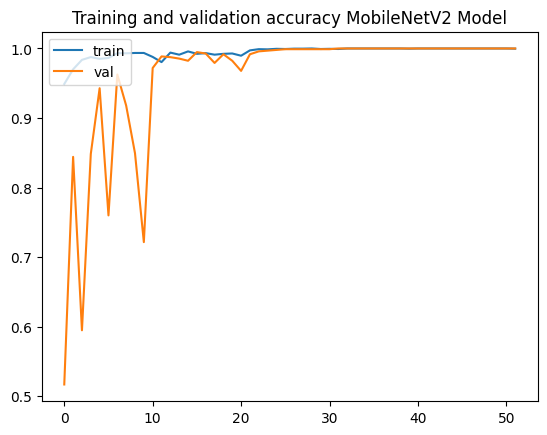

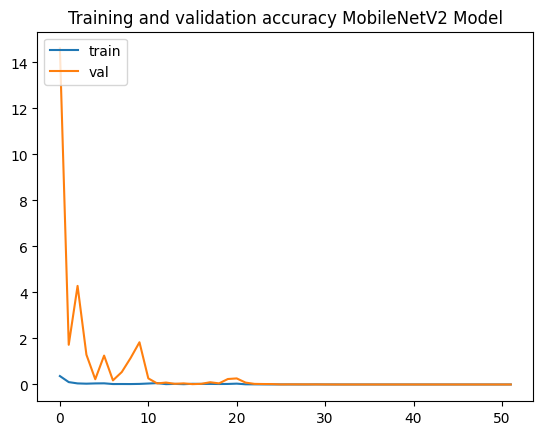

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.legend(['train', 'val'], loc='upper left')
plt.title ('Training and validation accuracy MobileNetV2 Model')

## MobileNetV2 Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="BellPaper_MobileNetV2_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
No

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
202/202 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9526
Epoch 1: val_accuracy improved from -inf to 0.69751, saving model to BellPaper_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


202/202 [==============================] - 40s 182ms/step - loss: 0.1465 - accuracy: 0.9526 - val_loss: 4.7685 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9787
Epoch 2: val_accuracy did not improve from 0.69751
202/202 [==============================] - 21s 104ms/step - loss: 0.0511 - accuracy: 0.9787 - val_loss: 6.6309 - val_accuracy: 0.6164 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9854
Epoch 3: val_accuracy did not improve from 0.69751
202/202 [==============================] - 21s 104ms/step - loss: 0.0436 - accuracy: 0.9854 - val_loss: 5.5889 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9809
Epoch 4: val_accuracy did not improve from 0.69751
202/202 [==============================] - 21s 105ms/step - loss: 0.0519 - accuracy: 0.9809 - val_loss: 20.8867 - v

INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


202/202 [==============================] - 36s 180ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 3.7787 - val_accuracy: 0.8067 - lr: 1.0000e-04
Epoch 10/100
202/202 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9978
Epoch 10: val_accuracy improved from 0.80665 to 0.88981, saving model to BellPaper_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0058 - accuracy: 0.9978 - val_loss: 1.7062 - val_accuracy: 0.8898 - lr: 1.0000e-04
Epoch 11/100
202/202 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9980
Epoch 11: val_accuracy improved from 0.88981 to 0.93451, saving model to BellPaper_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


202/202 [==============================] - 35s 174ms/step - loss: 0.0055 - accuracy: 0.9980 - val_loss: 0.6582 - val_accuracy: 0.9345 - lr: 1.0000e-04
Epoch 12/100
202/202 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9993
Epoch 12: val_accuracy improved from 0.93451 to 0.98233, saving model to BellPaper_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


202/202 [==============================] - 36s 179ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1567 - val_accuracy: 0.9823 - lr: 1.0000e-04
Epoch 13/100
202/202 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9993
Epoch 13: val_accuracy improved from 0.98233 to 0.99272, saving model to BellPaper_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0484 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 14/100
202/202 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9983
Epoch 14: val_accuracy did not improve from 0.99272
202/202 [==============================] - 21s 104ms/step - loss: 0.0045 - accuracy: 0.9983 - val_loss: 0.0434 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 15/100
202/202 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995
Epoch 15: val_accuracy improved from 0.99272 to 0.99688, saving model to BellPaper_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0074 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 16/100
202/202 [==============================] - ETA: 0s - loss: 4.7723e-04 - accuracy: 1.0000
Epoch 16: val_accuracy improved from 0.99688 to 1.00000, saving model to BellPaper_MobileNetV2_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Non_Augmented\assets


202/202 [==============================] - 36s 176ms/step - loss: 4.7723e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/100
202/202 [==============================] - ETA: 0s - loss: 2.7729e-04 - accuracy: 1.0000
Epoch 17: val_accuracy did not improve from 1.00000
202/202 [==============================] - 21s 103ms/step - loss: 2.7729e-04 - accuracy: 1.0000 - val_loss: 2.0564e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/100
202/202 [==============================] - ETA: 0s - loss: 1.9133e-04 - accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 1.00000
202/202 [==============================] - 21s 106ms/step - loss: 1.9133e-04 - accuracy: 1.0000 - val_loss: 6.3640e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/100
202/202 [==============================] - ETA: 0s - loss: 2.8618e-04 - accuracy: 1.0000
Epoch 19: val_accuracy did not improve from 1.00000
202/202 [==============================] - 21s 105ms/step - loss:

Text(0.5, 1.0, 'Training and validation loss MobileNetV2 Model')

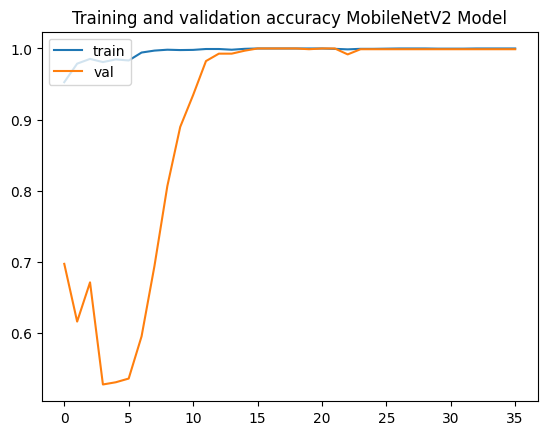

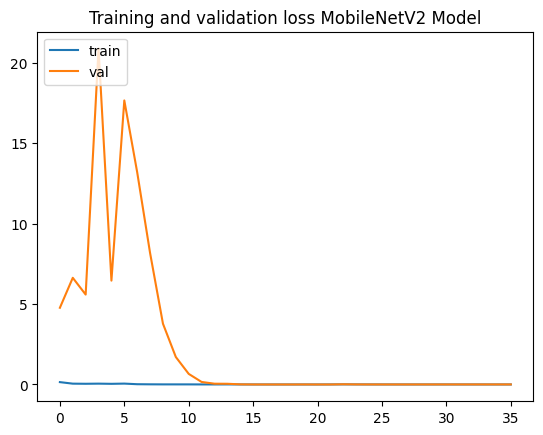

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.legend(['train', 'val'], loc='upper left')
plt.title ('Training and validation accuracy MobileNetV2 Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.legend(['train', 'val'], loc='upper left')
plt.title ('Training and validation loss MobileNetV2 Model')